# Import

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import pickle 

from pprint import pprint
from tqdm import tqdm

from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam 

from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, minmax_scale

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import BernoulliRBM
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.datasets import load_digits

from tensorflow.keras.callbacks import ModelCheckpoint

from scipy.ndimage import convolve

from scikeras.wrappers import KerasClassifier

from keras.utils import to_categorical

import collections 
import random

# Data Preparation

In [2]:
FULL_DATA = False
LE = LabelEncoder()
WINDOW_LENGTH = 5
ADD_ELEMENTS = True


concatenated_data = pd.read_csv("Concatenated Data.csv")

if FULL_DATA:
    raw_dataset = concatenated_data[["tempmax", "tempmin", "temp", "feelslikemax", "feelslikemin", "feelslike", "dew", "humidity", "windspeed", "sealevelpressure", "conditions"]]
else:
    raw_dataset = concatenated_data[["temp", "feelslike", "humidity", "windspeed", "sealevelpressure", "conditions"]]

raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])

t_arr = raw_dataset.copy().to_numpy()
X = []
y = []

for i in range(len(t_arr) - WINDOW_LENGTH):
    t_row = []
    for j in t_arr[i : i + WINDOW_LENGTH]:
        t_row.append(j[:-1])
    t_row = np.array(t_row).flatten()
    X.append(t_row)
    y.append(t_arr[i + WINDOW_LENGTH][-1])

X = np.array(X, "float32")
X = minmax_scale(X, feature_range=(0, 1))
y = np.array(y)

counts = dict(collections.Counter(y))
max_count = max(counts.values())

# Data Augmentation

if ADD_ELEMENTS:
    for key, value in counts.items():
        curX = []
        curY = []
        li, = np.where(y == key)
        for i in range((max_count - value) * 10):
            ci = random.choice(li)
            curX.append(X[ci])
            curY.append(y[ci])
        tX = X.tolist()
        tY = y.tolist()
        tX.extend(curX)
        tY.extend(curY)
        X = np.array(tX)
        y = np.array(tY)        

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2)
print(X_train.shape, X_test.shape, X_valid.shape, y_train.shape, y_valid.shape, y_test.shape)


C:\Users\Alaric\AppData\Local\Temp\ipykernel_15464\3232333252.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] = [word.replace(", ", "\n") if ("," in word) else word for word in raw_dataset["conditions"]]
C:\Users\Alaric\AppData\Local\Temp\ipykernel_15464\3232333252.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_dataset["conditions"] =  LE.fit_transform(raw_dataset["conditions"])


(23497, 25) (7344, 25) (5875, 25) (23497,) (5875,) (7344,)


# Implement : DBN + RFC

In [3]:
MLPipeline = Pipeline([
    ("MinMaxScaler", MinMaxScaler()),
    # ("DBN", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 10, verbose = 0)),
    ("RandomForestClassifier", RandomForestClassifier())
])

MLPipeline.fit(X_train, y_train)


Pipeline(steps=[('MinMaxScaler', MinMaxScaler()),
                ('RandomForestClassifier', RandomForestClassifier())])

In [4]:
y_pred = MLPipeline.predict(X_test)
accuracy_score(y_test, y_pred)

0.9749455337690632

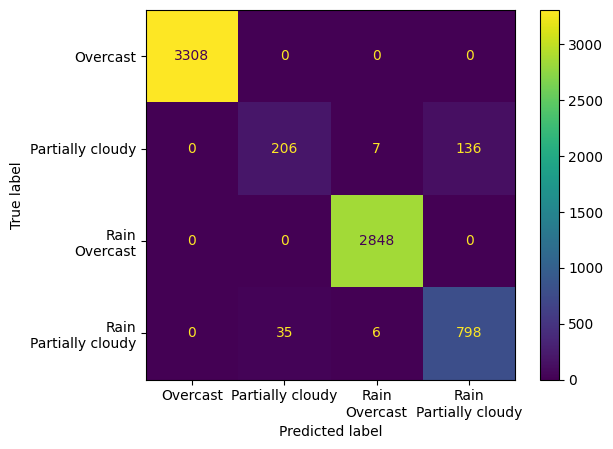

In [5]:
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = LE.classes_).plot()

# Implement : DBN + Bi - RNN

In [77]:
DLPipeline = Pipeline([
    ("MinMaxScaler", MinMaxScaler()),
    # ("DBN", BernoulliRBM(n_components = X_train.shape[1], learning_rate = 0.01, n_iter = 10, verbose = 0)),
    # ("MinMaxScalerOut", MinMaxScaler()),
])

DL_X_train = DLPipeline.fit_transform(X_train)
DL_X_valid = DLPipeline.transform(X_valid)
DL_X_test = DLPipeline.transform(X_test)
DL_Y_train = to_categorical(y_train)
DL_Y_valid = to_categorical(y_valid)
DL_Y_test = to_categorical(y_test)

In [64]:
DLPredictor = Sequential([
    layers.InputLayer((DL_X_train.shape[1], 1)),
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences = True)),
    layers.Bidirectional(layers.SimpleRNN(64, return_sequences = True)),
    layers.Bidirectional(layers.SimpleRNN(64)),
    layers.Flatten(),
    layers.Dense(DL_Y_train.shape[1], activation = "softmax")
])

DLPredictor.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [65]:
mcp_save = ModelCheckpoint(f"NO_DBN_BI_RNN_50.keras", save_best_only = True, monitor = "accuracy", mode = "max")

In [66]:
history = DLPredictor.fit(
    DL_X_train, DL_Y_train, 
    batch_size = 1024, 
    epochs = 50, 
    validation_split = 0.1, 
    validation_data = (DL_X_valid, DL_Y_valid), 
    callbacks = [mcp_save])

Epoch 1/50
23/23 [==============================] - 14s 366ms/step - loss: 1.1263 - accuracy: 0.4764 - val_loss: 1.0881 - val_accuracy: 0.5183
Epoch 2/50
23/23 [==============================] - 7s 327ms/step - loss: 1.0752 - accuracy: 0.5341 - val_loss: 1.0628 - val_accuracy: 0.5799
Epoch 3/50
23/23 [==============================] - 8s 342ms/step - loss: 1.0622 - accuracy: 0.5381 - val_loss: 1.0517 - val_accuracy: 0.5959
Epoch 4/50
23/23 [==============================] - 8s 329ms/step - loss: 1.0505 - accuracy: 0.5620 - val_loss: 1.0548 - val_accuracy: 0.5903
Epoch 5/50
23/23 [==============================] - 8s 331ms/step - loss: 1.0494 - accuracy: 0.5556 - val_loss: 1.0453 - val_accuracy: 0.5985
Epoch 6/50
23/23 [==============================] - 7s 322ms/step - loss: 1.0407 - accuracy: 0.5739 - val_loss: 1.0512 - val_accuracy: 0.5127
Epoch 7/50
23/23 [==============================] - 8s 331ms/step - loss: 1.0355 - accuracy: 0.5749 - val_loss: 1.0366 - val_accuracy: 0.5869
Epoch

In [73]:
DLPredictor = load_model("NO_DBN_BI_RNN_50.keras")

In [68]:
history = history.history 

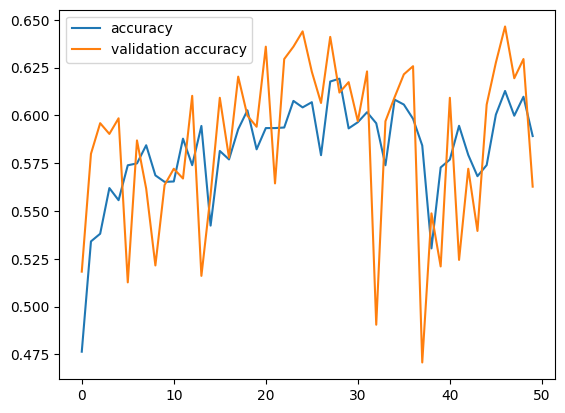

In [69]:
plt.figure()
plt.plot(history["accuracy"], label = "accuracy")
plt.plot(history["val_accuracy"], label = "validation accuracy")
plt.legend()
plt.show()

In [78]:
DL_Y_predict = DLPredictor.predict(DL_X_test)

230/230 [==============================] - 2s 7ms/step


In [79]:
accuracy_score(
    np.argmax(DL_Y_test, axis = 1), 
    np.argmax(DL_Y_predict, axis = 1))

0.9614651416122004

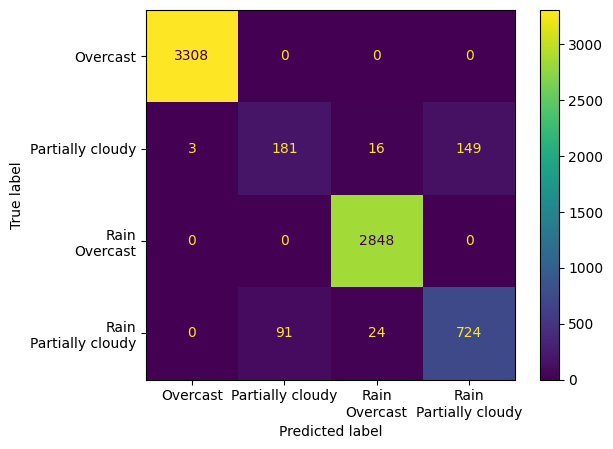

In [80]:
ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(
        np.argmax(DL_Y_test, axis = 1), 
        np.argmax(DL_Y_predict, axis = 1)), 
    display_labels = LE.classes_).plot()